# Surface properties of alternating site model

In [1]:
# ---------------------------------------------------
# Chain with alternating site energies and hoppings
# Study surface properties of finite chain
# ---------------------------------------------------

from __future__ import print_function # python3 style print
from pythtb import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams, cm
%matplotlib inline
rcParams.update({"text.usetex": True, "font.size": 16})

In [2]:
# to set up model for given surface energy shift and lambda
def set_model(n_cell,en_shift,lmbd):

  # set parameters of model
  t=-1.0       # average hopping
  Delta=-0.4*np.cos(lmbd)   # site energy alternation
  del_t=-0.3*np.sin(lmbd)   # bond strength alternation

  # construct bulk model
  lat=[[1.0]]
  orb=[[0.0],[0.5]]
  bulk_model=tbmodel(1,1,lat,orb)
  bulk_model.set_onsite([Delta,-Delta])
  bulk_model.add_hop(t+del_t, 0, 1, [0])
  bulk_model.add_hop(t-del_t, 1, 0, [1])

  # cut chain of length n_cell and shift energy on last site
  finite_model=bulk_model.cut_piece(n_cell,0)
  finite_model.set_onsite(en_shift,ind_i=2*n_cell-1,mode='add')

  return finite_model

In [3]:
# set Fermi energy and number of cells
Ef=0.18
n_cell=20
n_orb=2*n_cell

In [4]:
# set number of parameter values to run over
n_param=101

# initialize arrays
params=np.linspace(0.,1.,n_param)
eig_sav=np.zeros((n_orb,n_param),dtype=float)
xbar_sav=np.zeros((n_orb,n_param),dtype=float)
nocc_sav=np.zeros((n_param),dtype=int)
surf_sav=np.zeros((n_param),dtype=float)
count=np.zeros((n_orb),dtype=float)

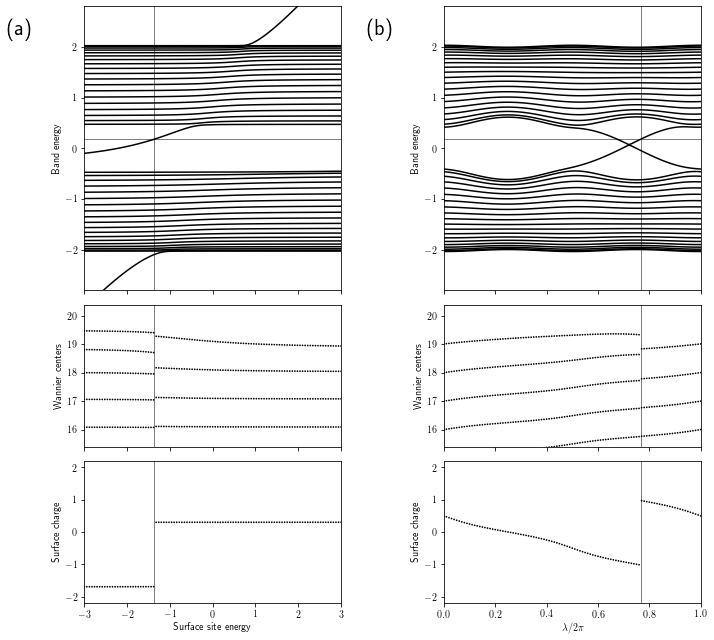

In [5]:
# initialize plots
mpl.rc('font',size=10)  # set global font size
fig,ax=plt.subplots(3,2,figsize=(10.,9.),
    gridspec_kw={'height_ratios':[2,1,1]},sharex="col")

# loop over two cases: vary surface site energy, or vary lambda
for mycase in ['surface energy','lambda']:

  if mycase == 'surface energy':
    (ax0,ax1,ax2)=ax[:,0]   # axes for plots in left panels
    ax0.text(-0.30,0.90,'(a)',size=22.,transform=ax0.transAxes)
    lmbd=0.15*np.pi*np.ones((n_param),dtype=float)
    en_shift=-3.0+6.0*params
    abscissa=en_shift
  elif mycase == 'lambda':
    (ax0,ax1,ax2)=ax[:,1]   # axes for plots in right panels
    ax0.text(-0.30,0.90,'(b)',size=22.,transform=ax0.transAxes)
    lmbd=params*2.*np.pi
    en_shift=0.2*np.ones((n_param),dtype=float)
    abscissa=params

  # loop over parameter values
  for j in range(n_param):
  
    # set up and solve model; store eigenvalues
    my_model=set_model(n_cell,en_shift[j],lmbd[j])
    (eval,evec)=my_model.solve_all(eig_vectors=True)
  
    # find occupied states
    nocc=(eval<Ef).sum()
    ovec=evec[0:nocc,:]
  
    # get Wannier centers
    xbar_sav[0:nocc,j]=my_model.position_hwf(ovec,0)
  
    # get electron count on each site
    # convert to charge (2 for spin; unit nuclear charge per site)
    # compute surface charge down to depth of 1/3 of chain
    for i in range(n_orb):
      count[i]=np.real(np.vdot(evec[:nocc,i],evec[:nocc,i]))
    charge=-2.*count+1.
    n_cut=int(0.67*n_orb)
    surf_sav[j]=0.5*charge[n_cut-1]+charge[n_cut:].sum()
  
    # save information for plots
    nocc_sav[j]=nocc
    eig_sav[:,j]=eval
  
  ax0.set_xlim(0.,1.)
  ax0.set_ylim(-2.8,2.8)
  ax0.set_ylabel(r"Band energy")
  ax0.axhline(y=Ef,color='k',linewidth=0.5)
  for n in range(n_orb):
    ax0.plot(abscissa,eig_sav[n,:],color='k')
  
  ax1.set_xlim(0.,1.)
  ax1.set_ylim(n_cell-4.6,n_cell+0.4)
  ax1.set_yticks(np.linspace(n_cell-4,n_cell,5))
  #ax1.set_ylabel(r"$\bar{x}$")
  ax1.set_ylabel(r"Wannier centers")
  for j in range(n_param):
    nocc=nocc_sav[j]
    ax1.scatter([abscissa[j]]*nocc,xbar_sav[:nocc,j],color='k',
      s=3.,marker='o',edgecolors='none')
  
  ax2.set_ylim(-2.2,2.2)
  ax2.set_yticks([-2.,-1.,0.,1.,2.])
  ax2.set_ylabel(r"Surface charge")
  if mycase == 'surface energy':
    ax2.set_xlabel(r"Surface site energy")
  elif mycase == 'lambda':
    ax2.set_xlabel(r"$\lambda/2\pi$")
  ax2.set_xlim(abscissa[0],abscissa[-1])
  ax2.scatter(abscissa,surf_sav,color='k',s=3.,marker='o',edgecolors='none')

  # vertical lines denote surface state at right end crossing the Fermi energy
  for j in range(1,n_param):
    if nocc_sav[j] != nocc_sav[j-1]:
      n=min(nocc_sav[j],nocc_sav[j-1])
      frac=(Ef-eig_sav[n,j-1])/(eig_sav[n,j]-eig_sav[n,j-1])
      a_jump=(1-frac)*abscissa[j-1]+frac*abscissa[j]
      if mycase == 'surface energy' or nocc_sav[j] < nocc_sav[j-1]:
        ax0.axvline(x=a_jump,color='k',linewidth=0.5)
        ax1.axvline(x=a_jump,color='k',linewidth=0.5)
        ax2.axvline(x=a_jump,color='k',linewidth=0.5)

fig.tight_layout()
plt.subplots_adjust(left=0.12,wspace=0.4)
#fig.savefig("chain_alt_surf.pdf")

plt.show()